<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/CV-2025/blob/main/Week_11/MovingMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
!pip install -q pytorch-lightning pytorch-metric-learning plotly clearml

In [17]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torchmetrics

In [18]:
#Enter your code here to implement Step 2 of the logging instruction as it is shown below
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
%env CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
env: CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I


In [19]:
class MovingMNIST(Dataset):
    def __init__(self, num_frames=20, img_size=64, train=True):
        self.mnist = MNIST(root='./data', train=train, download=True, transform=ToTensor())
        self.num_frames = num_frames
        self.img_size = img_size

    def __len__(self):
        return len(self.mnist) // 2

    def __getitem__(self, idx):
        digit1, label1 = self.mnist[2 * idx]
        digit2, label2 = self.mnist[2 * idx + 1]

        frames = []
        # Initialize positions within valid bounds (0 <= pos <= img_size - 28)
        pos1 = np.random.randint(0, self.img_size - 28 + 1, size=2)  # [x, y]
        pos2 = np.random.randint(0, self.img_size - 28 + 1, size=2)
        vel1 = np.random.randint(-3, 4, size=2)
        vel2 = np.random.randint(-3, 4, size=2)

        for _ in range(self.num_frames):
            frame = torch.zeros((1, self.img_size, self.img_size))

            # Update positions with bounce logic
            def update_pos(pos, vel):
                new_pos = pos + vel
                # Reflect velocity if out of bounds
                for i in range(2):  # x and y axes
                    if new_pos[i] < 0:
                        vel[i] *= -1
                        new_pos[i] = 0
                    elif new_pos[i] > (self.img_size - 28):
                        vel[i] *= -1
                        new_pos[i] = 2*(self.img_size - 28) - new_pos[i]
                return new_pos

            pos1 = update_pos(pos1, vel1)
            pos2 = update_pos(pos2, vel2)

            # Add digits to frame (positions now guaranteed valid)
            x1, y1 = int(pos1[0]), int(pos1[1])
            frame[:, y1:y1+28, x1:x1+28] += digit1.squeeze()
            x2, y2 = int(pos2[0]), int(pos2[1])
            frame[:, y2:y2+28, x2:x2+28] += digit2.squeeze()

            frames.append(frame.clamp(0, 1))

        video = torch.stack(frames)
        target = label1 + label2
        return video, target

In [20]:
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

class VideoClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv3d = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=(3, 3, 3)),  # Input: (B, C, T, H, W)
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),  # Reduces (T, H, W) by half
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3)),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2))
        )
        # Calculate input features dynamically
        self.example_input_array = torch.rand(1, 20, 1, 64, 64)  # (B, T, C, H, W)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 3 * 14 * 14, 128),  # Fixed: 64 * 3 * 14 * 14 = 37632
            nn.ReLU(),
            nn.Linear(128, 19)
        )
        self.train_acc = torchmetrics.Accuracy(task='multiclass', num_classes=19)
        self.val_acc = torchmetrics.Accuracy(task='multiclass', num_classes=19)
        self.test_acc = torchmetrics.Accuracy(task='multiclass', num_classes=19)

    def forward(self, x):
        x = x.permute(0, 2, 1, 3, 4)  # (B, C, T, H, W)
        features = self.conv3d(x)
        return self.classifier(features)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.test_acc(y_hat, y)
        self.log("test_acc", self.test_acc, on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_batch(batch, n_frames=4):
    """Plot first 4 frames of first 4 videos in batch"""
    videos, targets = batch
    fig, axes = plt.subplots(4, n_frames, figsize=(15, 8))

    for i in range(4):  # First 4 samples
        for j in range(n_frames):  # First n_frames
            frame_idx = j * (videos.shape[1] // n_frames)
            axes[i,j].imshow(videos[i, frame_idx, 0], cmap='gray')
            axes[i,j].set_title(f"Target: {targets[i].item()}")
            axes[i,j].axis('off')
    plt.tight_layout()
    plt.show()



In [22]:
from clearml import Task

# Initialize ClearML
task = Task.init(project_name="MovingMNIST", task_name="digits_sum_classification")

# Define datasets
train_dataset = MovingMNIST(train=True)
val_dataset = MovingMNIST(train=False)
test_dataset = MovingMNIST(train=False)  # Using same as val for demo (replace with real test set)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    dirpath="./checkpoints",
    filename="best_model"
)
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5)

# Trainer
trainer = pl.Trainer(
    max_epochs=3,
    logger=CSVLogger(save_dir="./logs"),
    callbacks=[checkpoint_callback, early_stop_callback],
    accelerator="auto"
)

# Train
model = VideoClassifier()
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params | Mode  | In sizes           | Out sizes         
----------------------------------------------------------------------------------------------------
0 | conv3d     | Sequential         | 56.3 K | train | [1, 1, 20, 64, 64] | [1, 64, 3, 14, 14]
1 | classifier | Sequential         | 4.8 M  | train | [1, 64, 3, 14, 14] | [1, 19]           
2 | train_acc  | MulticlassAccuracy | 0      | train | ?                  | ?                 
3 | val_acc    | MulticlassAccuracy | 0      | train | ?                  | ?                 
4 | test_acc   | MulticlassAccuracy | 0      | t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


In [23]:
# Test (after training)
trainer.test(model, test_loader)

# Print final metrics
print(f"\nFinal Test Accuracy: {model.test_acc.compute().item():.2%}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.10239999741315842    │
└───────────────────────────┴───────────────────────────┘


Final Test Accuracy: 0.00%


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning:

The ``compute`` method of metric MulticlassAccuracy was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.



In [24]:
batch = next(iter(train_loader))
output = model(batch[0])
print(output.shape)  # Should be (B, 19)

torch.Size([32, 19])


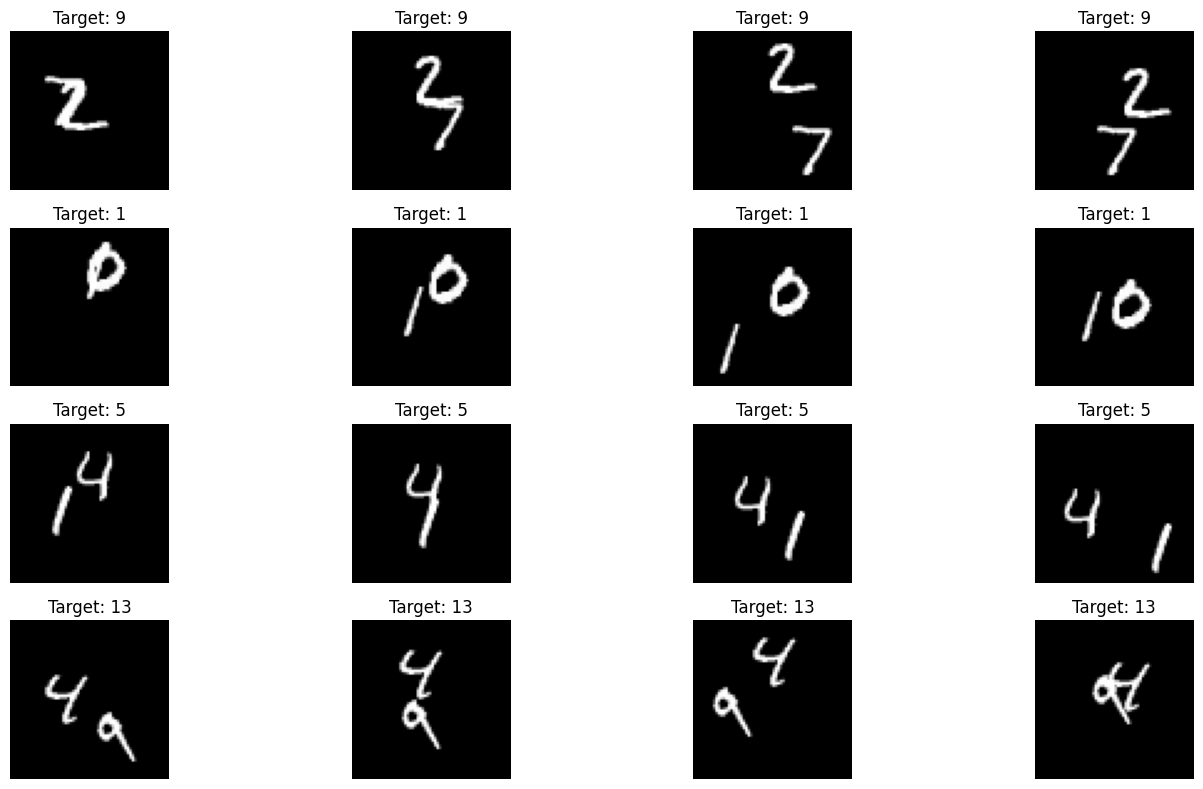

In [25]:
# Visualize a test batch
test_batch = next(iter(test_loader))
visualize_batch(test_batch)